# Построение диалоговой системы с использованием обучения с подкреплением

### Цели
1. Изучить различные методы обучения с подкреплением в задачах резервации места в ресторане
2. Выбрать наиболее оптимальную модель в данной ситуации

### Метрики 
В качестве метрики качестве моделей будем использова среднее число успехов(success_rate). \
Также имеет смысл фиксировать среднее "вознаграждение" модели(average_reward)
### Датасет
https://github.com/google-research-datasets/simulated-dialogue/tree/master/sim-R \
Датасет представляет из себя набор диалогов, где пользователь пытается забронировать столик, а агент пытается ему в этом помочь. \
Датасет изначально разделен на тренировочный, валидационный и тестовый сеты \
Каждый набор состоит из диалоговой пары(реплика агента - реплика пользователя) \
Пример диалоговый пары

In [1]:
{
          "dialogue_state": [],
          "system_acts": [],
          "system_utterance": {
            "slots": [],
            "text": "",
            "tokens": []
          },
          "user_acts": [],
          "user_utterance": {
            "slots": [],
            "text": ...,
            "tokens": []
          }
 }

{'dialogue_state': [],
 'system_acts': [],
 'system_utterance': {'slots': [], 'text': '', 'tokens': []},
 'user_acts': [],
 'user_utterance': {'slots': [], 'text': Ellipsis, 'tokens': []}}

### Описание задачи
Модель и пользователь общаются посредство словарей вида: {'intent': "", 'request_slots': {}, 'inform_slots': {}} \
**intent** принимает различные значения, характеризующие намерение отправителя  \
**request_slots** содержит слоты, запращиваемые отправителем для следующего шага \
**inform_slots** содержит слоты, информирующие того, кому отправляют о значении какого-либо слота, например о названии ресторана \
В ходе диалога задача агента заполнить все необходимые слоты для получения reservation_id, таким образом, чтобы полученная бронь соответствовала требованиям, заданным пользователем. \
Когда диалог достигает определенной длинны, он прерывается и диалог считается проваленным \
В случае если агенту удалось найти резервацию, соответсвующую ограничениям пользователя диалог считается успешным 

### План
1. Извлечь всю необходимую информацию из датасета для построения и обучения диалоговой системы 
2. Построить саму диалоговую системы \
    2.1 Симулятор поведения пользователя\
    2.2 Агент\
    2.3 Модуль, который внедряет ошибки в диалоги, для повышения устойчивости модели(ErrorModelController)\
    2.4 Модуль для работы с базой данных\
    2.5 Диалоговый менеджер\
    2.6 Финальный класс, объединяющий все выше перечисленные модули в одну систему
3. Обучить baseline и замерить качество на валидационном сете
4. Обучить ещё одну модель и так же замерить качество на валидационном сете
5. Обучить последнюю модель, с более глубокой архитектурой и замерить качество на валидационном сете
6. Выбрать лучшую модель
7. Замерить её качество на тестовом сете


### Источники
End-to-End Task-Completion Neural Dialogue Systems https://arxiv.org/pdf/1703.01008.pdf \
Playing Atari with Deep Reinforcement Learning https://arxiv.org/pdf/1312.5602.pdf (для DQN агента) \
Deep Reinforcement Learning with Double Q-learning https://arxiv.org/pdf/1509.06461.pdf (для DDQN агента)

In [2]:
import torch
import torch.nn as nn 
from torch.optim import Adam 
from torch.nn import MSELoss

import numpy as np
import pandas as pd 

from tqdm.notebook import tqdm 
import wandb

import pickle
import json
import re
import random
import copy
import math
import os 
from pathlib import Path
from collections import defaultdict
import time 

# Предобработка данных

Для корректной работы GO системы нам необходимо извлечь:
* user_goals
* саму базу данных, к которой мы и будем обращаться
* все возможные значения для каждого из слотов, для работы ErrorModelController

In [ ]:
DATA_OUPUT_FOLDER = Path('/kaggle/working/')
DATA_INPUT_FOLDER = Path('/kaggle/input/coursework-dt')

# Raw data
train = pd.read_json(DATA_INPUT_FOLDER / 'train.json')
test = pd.read_json(DATA_INPUT_FOLDER / 'test.json')
dev = pd.read_json(DATA_INPUT_FOLDER / 'dev.json')

data = {
    'train': train,
    'test': test,
    'dev': dev
}

## Извлечение user_goals из датасета
Несколько шагов, чтобы извлечь user_goals
1) нас интересует только первая реплика из диалога(не считая Greeting) потому что как правило в ней и содержится самая важная информация о запросе пользователя \
2) на выходе user_goal должен представлять из себя словарь вида {'inform_slots': {}, 'request_slots': {}} \
3) все слоты со значениями из "dialogue_state" мы добавляем в inform_slots \
4) таким образом мы получаем users_goals 

Далее мы удаляем все слоты со значением 'dontcare', обозночающее, что человеку безразлично значение этого слота, поэтому он не несёт никакой полезной информации \
В результате в данных образуется несколько полностью пустых user_goals от которых мы тоже избавляемся

In [ ]:
def generate_simple_user_goals(x):
    state = x[1]['dialogue_state'] if len(x) > 1 else x[0]['dialogue_state']

    res = {}
    res['inform_slots'] = {}
    res['request_slots'] = {}
    for i in state:
        slot = i['slot']
        value = i['value']
        res['inform_slots'][slot] = value 
    return res

def get_user_goals(df):
    turns = df['turns']
    return turns.apply(generate_simple_user_goals).to_list()

def clear_dontcare_slots(goals):
    return list(map(lambda goal: {**goal, 'inform_slots': {k:v for k, v in goal['inform_slots'].items() if v != 'dontcare'}}, goals))

def clear_empty_goals(goals):
    return list(filter(lambda x: x['inform_slots'], goals))

def data_processing_pipeline(df):
    goals = get_user_goals(df)
    goals = clear_dontcare_slots(goals)
    goals = clear_empty_goals(goals)
    return goals

goals = {k:data_processing_pipeline(v) for k, v in data.items()}

for key in goals:
    print(len(goals[key]), end=', ')

for k, v in goals.items():
    with open(DATA_OUPUT_FOLDER / f'{k}_goals.json', 'w', encoding='utf-8') as file:
        for goal in v:
            file.write(json.dumps(goal) + '\n')

В итоге, мы получаем тренировочный сет размера 1082, валидационных сет размера 339 и тестовый размера 753 \
В следствии большего числа эпизодов, такого размера достаточно, чтобы модель смогла нормально обучиться

## Получение всех возможных значений слотов
В дальнейшем код мы извлекаем все возможные значения, который может принимать каждый слот в датасете. Например: все возможные названия ресторанов. \
Полученный результат можно использовать в формировании базы данных, а так же в ErrorStateController для замены значений слотов на случайные

In [ ]:
def get_dialogue_state(df):
    turns = df['turns'].explode()
    dialogue_state = turns.map(lambda x: x['dialogue_state'])
    return dialogue_state.dropna()

def get_exploded_dialogue_slots(dialogue_state):
    dialogue_dicts = dialogue_state.explode()
    exploded_dialogue_slots = dialogue_dicts.apply(pd.Series).drop(0, axis=1).dropna()
    return exploded_dialogue_slots

slots = defaultdict(set)

for _, df in tqdm(data.items()):
    dialogue_state = get_dialogue_state(df)
    exploded_dialogue_slots = get_exploded_dialogue_slots(dialogue_state)
    possible_slots = exploded_dialogue_slots['slot'].unique()

    for key in possible_slots:
        slots[key] = slots[key].union(exploded_dialogue_slots[exploded_dialogue_slots['slot'] == key]['value'].unique())
        
for key in slots:
    slots[key] = [i for i in slots[key] if i != 'dontcare']

with open(DATA_OUPUT_FOLDER / 'restaurant_db_dict.pickle', 'wb') as file:
    pickle.dump(dict(slots), file)

## Генерация базы данных
База данных будет симулировать настоящее API, к которому обращается система для получения информации о доступных слотах для резервации столика в ресторане


In [ ]:
goals = []
for key in data:
    with open(DATA_INPUT_FOLDER / f'{key}_goals.json') as file:
        goals += list(map(lambda x:json.loads(x), file.readlines()))

with open(DATA_INPUT_FOLDER / 'restaurant_db_dict.pickle', 'rb') as file:
    slots = pickle.load(file)

informs = list(map(lambda x: x['inform_slots'], goals))

possible_restaurant_names = slots['restaurant_name']
possible_locations = slots['location']
possible_restaurants = [{'name': name, 'location': location} for name in possible_restaurant_names for location in possible_locations]
possible_restaurants_hash_table = {(i['name'], i['location']): defaultdict(list) for i in possible_restaurants}

informs_with_location_and_restaurant_name = list(filter(lambda x: all([x.get('location', None), x.get('restaurant_name', None)]), informs))
for i in informs_with_location_and_restaurant_name:
    key = (i['restaurant_name'], i['location'])

    if i.get('meal', None) and i['meal'] not in possible_restaurants_hash_table[key]['meal']:
        possible_restaurants_hash_table[key]['meal'].append(i['meal'])
    
    if i.get('category', None) and i['category'] not in possible_restaurants_hash_table[key]['category']:
        possible_restaurants_hash_table[key]['category'].append(i['category'])

    if i.get('rating', None) and i['rating'] not in possible_restaurants_hash_table[key]['rating']:
        possible_restaurants_hash_table[key]['rating'].append(i['rating'])

    if i.get('price_range', None) and i['price_range'] not in possible_restaurants_hash_table[key]['price_range']:
        possible_restaurants_hash_table[key]['price_range'].append(i['price_range'])

informs_with_only_location = list(filter(lambda x: all([x.get('location', None), not x.get('restaurant_name', None)]), informs))
for i in informs_with_only_location:
    for name in possible_restaurant_names:
        key = (name, i['location'])

        if i.get('meal', None) and i['meal'] not in possible_restaurants_hash_table[key]['meal'] and not possible_restaurants_hash_table[key]['meal'] and i['meal'] != 'dontcare':
            possible_restaurants_hash_table[key]['meal'].append(i['meal'])
        
        if i.get('category', None) and i['category'] not in possible_restaurants_hash_table[key]['category'] and not possible_restaurants_hash_table[key]['category'] and i['category'] != 'dontcare':
            possible_restaurants_hash_table[key]['category'].append(i['category'])

        if i.get('rating', None) and i['rating'] not in possible_restaurants_hash_table[key]['rating'] and not possible_restaurants_hash_table[key]['rating'] and i['rating'] != 'dontcare':
            possible_restaurants_hash_table[key]['rating'].append(i['rating'])

        if i.get('price_range', None) and i['price_range'] not in possible_restaurants_hash_table[key]['price_range'] and not possible_restaurants_hash_table[key]['price_range'] and i['price_range'] != 'dontcare':
            possible_restaurants_hash_table[key]['price_range'].append(i['price_range'])

informs_with_only_restaurant_name = list(filter(lambda x: all([not x.get('location', None), x.get('restaurant_name', None)]), informs))
for i in informs_with_only_restaurant_name:
    for name in possible_locations:
        key = (i['restaurant_name'], possible_locations)

        if i.get('meal', None) and i['meal'] not in possible_restaurants_hash_table[key]['meal'] and not possible_restaurants_hash_table[key]['meal'] and i['meal'] != 'dontcare':
            possible_restaurants_hash_table[key]['meal'].append(i['meal'])
        
        if i.get('category', None) and i['category'] not in possible_restaurants_hash_table[key]['category'] and not possible_restaurants_hash_table[key]['category'] and i['category'] != 'dontcare':
            possible_restaurants_hash_table[key]['category'].append(i['category'])

        if i.get('rating', None) and i['rating'] not in possible_restaurants_hash_table[key]['rating'] and not possible_restaurants_hash_table[key]['rating'] and i['rating'] != 'dontcare':
            possible_restaurants_hash_table[key]['rating'].append(i['rating'])

        if i.get('price_range', None) and i['price_range'] not in possible_restaurants_hash_table[key]['price_range'] and not possible_restaurants_hash_table[key]['price_range'] and i['price_range'] != 'dontcare':
            possible_restaurants_hash_table[key]['price_range'].append(i['price_range'])

possible_restaurants_hash_table = {key: dict(value) for key, value in possible_restaurants_hash_table.items()}
possible_restaurants_final = [{'restaurant_name': key[0], 'location': key[1], 'category': category, 'price_range': price_range, 'meal': meal, 'rating': rating} for key, value in possible_restaurants_hash_table.items() for category in value['category'] for price_range in value['price_range'] for meal in value['meal'] for rating in value['rating']]

possible_num_people = slots['num_people']
possible_date = slots['date']
possible_time = slots['time']

possible_reservations = [{'num_people': num_people, 'date': date, 'time': time, **possible_restaurant} for num_people in possible_num_people for date in possible_date for time in possible_time for possible_restaurant in possible_restaurants_final]
possible_reservations = {index: reservation for index, reservation in enumerate(possible_reservations)}

with open(DATA_OUPUT_FOLDER / 'restaurant_db.pickle', 'wb') as file:
    pickle.dump(possible_reservations, file)

In [ ]:
# Пример того, как выглядит база данных
{
     0: {
         'num_people': '2',
         'date': 'friday',
         'time': '5 pm',
         'restaurant_name': '.ink',
         'location': 'kirkland',
         'category': 'thai',
         'price_range': 'expensive',
         'meal': 'lunch',
         'rating': 'zagat rated'},
     1: {
         'num_people': '2',
         'date': 'friday',
         'time': '5 pm',
         'restaurant_name': '.ink',
         'location': 'los altos',
         'category': 'italian',
         'price_range': 'inexpensive',
         'meal': 'brunch',
         'rating': 'zagat rated'},
     2: {
         'num_people': '2',
         'date': 'friday',
         'time': '5 pm',
         'restaurant_name': '.ink',
         'location': 'madison',
         'category': 'mediterranean',
         'price_range': 'moderately priced',
         'meal': 'dinner',
         'rating': 'zagat rated'},
};

# Диалоговая система

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'; device

'cpu'

## константы
Для дальнейшего удобства объявим несколько констант, которые будут использоваться в каждом из дальнейших компонентов

In [4]:
# Специальные наполнители для слотов
PLACEHOLDER = 'PLACEHOLDER'  # Для informs, отправляемыъ агентом(чтобы диалоговый менеджер мог поставить вместо них значения из бд)
UNK = 'UNK'  # Для requests, отправляемых агентом или пользователем
ANYTHING = 'ANYTHING'  # Для слотов, значение принимаемые, которыми неважно для пользователя
NO_MATCH = 'no match available'  # Если невозможно найти значение слота, при заданных ограничениях

# Все возможные intents
INFORM = 'inform'
REQUEST = 'request'
THANKS = 'thanks'
REJECT = 'reject'
DONE = 'done'
MATCH_FOUND = 'match_found'

# Используются как при проверке constraint_check, так и для функции вознаграждения 
FAIL = -1
NO_OUTCOME = 0
SUCCESS = 1

# Возможные режимы работы бота(для быстрой смены датасетов)
TRAIN = 'TRAIN'
TEST = 'TEST'
DEV = 'DEV'

# Все возможные намерения пользователя в симуляторе
usersim_intents = [INFORM, REQUEST, THANKS, REJECT, DONE]

# Главный слот, поиск значения для которого, является главной целью агента
usersim_default_key = 'reservation_id'

# Название ресторана, этот слот, должен информироваться первым 
usersim_required_init_inform_keys = ['restaurant_name']

# Все возможные значения для inform и request слотов агента
agent_inform_slots = ["restaurant_name", "date", "time", "meal", "location", "price_range", "category", "rating", usersim_default_key]

agent_request_slots = ["restaurant_name", "date", "time", "meal", "location", "price_range", "category", "rating", "num_people", usersim_default_key]

# Все возможные намерения для агента
# Используемя нейронная сеть, возвращает индексы данного списка, в соответсвии актуальности того или инога действия в текущей ситуации
agent_actions = [
    {'intent': DONE, 'inform_slots': {}, 'request_slots': {}},  # Triggers closing of conversation
    {'intent': MATCH_FOUND, 'inform_slots': {}, 'request_slots': {}}
]
for slot in agent_inform_slots:
    # Must use intent match found to inform this, but still have to keep in agent inform slots
    if slot == usersim_default_key:
        continue
    agent_actions.append({'intent': INFORM, 'inform_slots': {slot: PLACEHOLDER}, 'request_slots': {}})
for slot in agent_request_slots:
    agent_actions.append({'intent': REQUEST, 'inform_slots': {}, 'request_slots': {slot: UNK}})

# Rule-based политика
rule_requests = ['restaurant_name', 'time', 'location', 'date', 'num_people']

# Данные слоты не должны запращиваться агентом, а так же их значения не должны быть запращиваемы в базе данных
no_query_keys = ['num_people', usersim_default_key]

# Все возможные действия (для ST.get_state())
all_intents = [INFORM, REQUEST, DONE, MATCH_FOUND, THANKS, REJECT]

# Все возможные слоты (для ST.get_state())
all_slots = ["restaurant_name", "date", "time", "meal", "location", "price_range", "category", "rating", "num_people", usersim_default_key]


Функции утилиты
* Функция корвертирующая список в словарь
* Функция для удаления ключей с пустыми значения из словаря
* Функция возвращающая reward для агента

In [5]:
def convert_list_to_dict(lst):
    """
    Convert list to dict where the keys are the list elements, and the values are the indices of the elements in the list.

    Parameters:
        lst (list)

    Returns:
        dict
    """

    if len(lst) > len(set(lst)):
        raise ValueError('List must be unique!')
    return {k: v for v, k in enumerate(lst)}


def remove_empty_slots(dic):
    """
    Removes all items with values of '' (ie values of empty string).

    Parameters:
        dic (dict)
    """

    for id in list(dic.keys()):
        for key in list(dic[id].keys()):
            if dic[id][key] == '':
                dic[id].pop(key)


def reward_function(success, max_round):
    """
    Return the reward given the success.

    Return -1 + -max_round if success is FAIL, -1 + 2 * max_round if success is SUCCESS and -1 otherwise.

    Parameters:
        success (int)

    Returns:
        int: Reward
    """

    reward = -1
    if success == FAIL:
        reward += -max_round
    elif success == SUCCESS:
        reward += 2 * max_round
    return reward


## Симулятор пользователя

Первый из компонентов, симулирует поведение реального пользователя, используя для этого переданные user_goals. \
Как работает?
* В каждом эпизоде выберает рандомную цель из user_goals( user_goals выглядит как {'request_slots': {...}, 'inform_slots': {...}} )
* Возвращает первоначальное действие( метод _return_init_action)
* Метод step вызывается для каждого действия, возвращаемого агентом, в зависимости от параметра agent_action, возвращает определенное действие пользователя, а также reward, done(индикирует закончен ли диалог) и succes(1 если диалог успешен, 0 если нет)
* Когда агент возвращает действие с intent = 'MATCH_FOUND', симулятор проверяет на соответствие ограничениям из goal, если всё в порядке, инициализирует конец диалога с constraint_check = SUCCESS, в обратно случае отвергает агента
* Если диалог длится слишком долго, прерывает диалог

In [6]:
class UserSimulator:
    """Simulates a real user, to train the agent with reinforcement learning."""

    def __init__(self, goal_list, constants, database, by_order=False):
        """
        The constructor for UserSimulator. Sets dialogue config variables.

        Parameters:
            goal_list (list): User goals loaded from file
            constants (dict): Dict of constants loaded from file
            database (dict): The database in the format dict(long: dict)
        """

        self.goal_list = goal_list
        self.max_round = constants['run']['max_round_num']
        self.default_key = usersim_default_key
        # A list of REQUIRED to be in the first action inform keys
        self.init_informs = usersim_required_init_inform_keys
        self.no_query = no_query_keys

        # TEMP ----
        self.database = database
        # ---------
        
        self.by_order = by_order
        if by_order:
            self.current_ix = 0

    def reset(self):
        """
        Resets the user sim. by emptying the state and returning the initial action.

        Returns:
            dict: The initial action of an episode
        """
        if not self.by_order:
            self.goal = random.choice(self.goal_list)
        else:
            self.goal = self.goal_list[self.current_ix]
            self.current_ix += 1
        # Add default slot to requests of goal
        self.goal['request_slots'][self.default_key] = UNK
        self.state = {}
        # Add all inform slots informed by agent or user sim to this dict
        self.state['history_slots'] = {}
        # Any inform slots for the current user sim action, empty at start of turn
        self.state['inform_slots'] = {}
        # Current request slots the user sim wants to request
        self.state['request_slots'] = {}
        # Init. all informs and requests in user goal, remove slots as informs made by user or agent
        self.state['rest_slots'] = {}
        self.state['rest_slots'].update(self.goal['inform_slots'])
        self.state['rest_slots'].update(self.goal['request_slots'])
        self.state['intent'] = ''
        # False for failure, true for success, init. to failure
        self.constraint_check = FAIL

        return self._return_init_action()

    def _return_init_action(self):
        """
        Returns the initial action of the episode.

        The initial action has an intent of request, required init. inform slots and a single request slot.

        Returns:
            dict: Initial user response
        """

        # Always request
        self.state['intent'] = REQUEST

        if self.goal['inform_slots']:
            # Pick all the required init. informs, and add if they exist in goal inform slots
            for inform_key in self.init_informs:
                if inform_key in self.goal['inform_slots']:
                    self.state['inform_slots'][inform_key] = self.goal['inform_slots'][inform_key]
                    self.state['rest_slots'].pop(inform_key)
                    self.state['history_slots'][inform_key] = self.goal['inform_slots'][inform_key]
            # If nothing was added then pick a random one to add
            if not self.state['inform_slots']:
                key, value = random.choice(list(self.goal['inform_slots'].items()))
                self.state['inform_slots'][key] = value
                self.state['rest_slots'].pop(key)
                self.state['history_slots'][key] = value

        # Now add a request, do a random one if something other than def. available
        self.goal['request_slots'].pop(self.default_key)
        if self.goal['request_slots']:
            req_key = random.choice(list(self.goal['request_slots'].keys()))
        else:
            req_key = self.default_key
        self.goal['request_slots'][self.default_key] = UNK
        self.state['request_slots'][req_key] = UNK

        user_response = {}
        user_response['intent'] = self.state['intent']
        user_response['request_slots'] = copy.deepcopy(self.state['request_slots'])
        user_response['inform_slots'] = copy.deepcopy(self.state['inform_slots'])

        return user_response

    def step(self, agent_action):
        """
        Return the response of the user sim. to the agent by using rules that simulate a user.

        Given the agent action craft a response by using deterministic rules that simulate (to some extent) a user.
        Some parts of the rules are stochastic. Check if the agent has succeeded or lost or still going.

        Parameters:
            agent_action (dict): The agent action that the user sim. responds to

        Returns:
            dict: User sim. response
            int: Reward
            bool: Done flag
            int: Success: -1, 0 or 1 for loss, neither win nor loss, win
        """

        # Assertions -----
        # No UNK in agent action informs
        for value in agent_action['inform_slots'].values():
            assert value != UNK
            assert value != PLACEHOLDER
        # No PLACEHOLDER in agent at all
        for value in agent_action['request_slots'].values():
            assert value != PLACEHOLDER
        # ----------------

        self.state['inform_slots'].clear()
        self.state['intent'] = ''

        done = False
        success = NO_OUTCOME
        # First check round num, if equal to max then fail
        if agent_action['round'] == self.max_round:
            done = True
            success = FAIL
            self.state['intent'] = DONE
            self.state['request_slots'].clear()
        else:
            agent_intent = agent_action['intent']
            if agent_intent == REQUEST:
                self._response_to_request(agent_action)
            elif agent_intent == INFORM:
                self._response_to_inform(agent_action)
            elif agent_intent == MATCH_FOUND:
                self._response_to_match_found(agent_action)
            elif agent_intent == DONE:
                success = self._response_to_done()
                self.state['intent'] = DONE
                self.state['request_slots'].clear()
                done = True

        # Assumptions -------
        # If request intent, then make sure request slots
        if self.state['intent'] == REQUEST:
            assert self.state['request_slots']
        # If inform intent, then make sure inform slots and NO request slots
        if self.state['intent'] == INFORM:
            assert self.state['inform_slots']
            assert not self.state['request_slots']
        assert UNK not in self.state['inform_slots'].values()
        assert PLACEHOLDER not in self.state['request_slots'].values()
        # No overlap between rest and hist
        for key in self.state['rest_slots']:
            assert key not in self.state['history_slots']
        for key in self.state['history_slots']:
            assert key not in self.state['rest_slots']
        # All slots in both rest and hist should contain the slots for goal
        for inf_key in self.goal['inform_slots']:
            assert self.state['history_slots'].get(inf_key, False) or self.state['rest_slots'].get(inf_key, False)
        for req_key in self.goal['request_slots']:
            assert self.state['history_slots'].get(req_key, False) or self.state['rest_slots'].get(req_key,
                                                                                                   False), req_key
        # Anything in the rest should be in the goal
        for key in self.state['rest_slots']:
            assert self.goal['inform_slots'].get(key, False) or self.goal['request_slots'].get(key, False)
        assert self.state['intent'] != ''
        # -----------------------

        user_response = {}
        user_response['intent'] = self.state['intent']
        user_response['request_slots'] = copy.deepcopy(self.state['request_slots'])
        user_response['inform_slots'] = copy.deepcopy(self.state['inform_slots'])

        reward = reward_function(success, self.max_round)

        return user_response, reward, done, True if success is 1 else False

    def _response_to_request(self, agent_action):
        """
        Augments the state in response to the agent action having an intent of request.

        There are 4 main cases for responding.

        Parameters:
            agent_action (dict): Intent of request with standard action format (including 'speaker': 'Agent' and
                                 'round_num': int)
        """

        agent_request_key = list(agent_action['request_slots'].keys())[0]
        # First Case: if agent requests for something that is in the user sims goal inform slots, then inform it
        if agent_request_key in self.goal['inform_slots']:
            self.state['intent'] = INFORM
            self.state['inform_slots'][agent_request_key] = self.goal['inform_slots'][agent_request_key]
            self.state['request_slots'].clear()
            self.state['rest_slots'].pop(agent_request_key, None)
            self.state['history_slots'][agent_request_key] = self.goal['inform_slots'][agent_request_key]
        # Second Case: if the agent requests for something in user sims goal request slots and it has already been
        # informed, then inform it
        elif agent_request_key in self.goal['request_slots'] and agent_request_key in self.state['history_slots']:
            self.state['intent'] = INFORM
            self.state['inform_slots'][agent_request_key] = self.state['history_slots'][agent_request_key]
            self.state['request_slots'].clear()
            assert agent_request_key not in self.state['rest_slots']
        # Third Case: if the agent requests for something in the user sims goal request slots and it HASN'T been
        # informed, then request it with a random inform
        elif agent_request_key in self.goal['request_slots'] and agent_request_key in self.state['rest_slots']:
            self.state['request_slots'].clear()
            self.state['intent'] = REQUEST
            self.state['request_slots'][agent_request_key] = UNK
            rest_informs = {}
            for key, value in list(self.state['rest_slots'].items()):
                if value != 'UNK':
                    rest_informs[key] = value
            if rest_informs:
                key_choice, value_choice = random.choice(list(rest_informs.items()))
                self.state['inform_slots'][key_choice] = value_choice
                self.state['rest_slots'].pop(key_choice)
                self.state['history_slots'][key_choice] = value_choice
        # Fourth and Final Case: otherwise the user sim does not care about the slot being requested, then inform
        # 'anything' as the value of the requested slot
        else:
            assert agent_request_key not in self.state['rest_slots']
            self.state['intent'] = INFORM
            self.state['inform_slots'][agent_request_key] = ANYTHING
            self.state['request_slots'].clear()
            self.state['history_slots'][agent_request_key] = ANYTHING

    def _response_to_inform(self, agent_action):
        """
        Augments the state in response to the agent action having an intent of inform.

        There are 2 main cases for responding. Add the agent inform slots to history slots,
        and remove the agent inform slots from the rest and request slots.

        Parameters:
            agent_action (dict): Intent of inform with standard action format (including 'speaker': 'Agent' and
                                 'round_num': int)
        """

        agent_inform_key = list(agent_action['inform_slots'].keys())[0]
        agent_inform_value = agent_action['inform_slots'][agent_inform_key]

        assert agent_inform_key != self.default_key

        # Add all informs (by agent too) to hist slots
        self.state['history_slots'][agent_inform_key] = agent_inform_value
        # Remove from rest slots if in it
        self.state['rest_slots'].pop(agent_inform_key, None)
        # Remove from request slots if in it
        self.state['request_slots'].pop(agent_inform_key, None)

        # First Case: If agent informs something that is in goal informs and the value it informed doesnt match,
        # then inform the correct value
        if agent_inform_value != self.goal['inform_slots'].get(agent_inform_key, agent_inform_value):
            self.state['intent'] = INFORM
            self.state['inform_slots'][agent_inform_key] = self.goal['inform_slots'][agent_inform_key]
            self.state['request_slots'].clear()
            self.state['history_slots'][agent_inform_key] = self.goal['inform_slots'][agent_inform_key]
        # Second Case: Otherwise pick a random action to take
        else:
            # - If anything in state requests then request it
            if self.state['request_slots']:
                self.state['intent'] = REQUEST
            # - Else if something to say in rest slots, pick something
            elif self.state['rest_slots']:
                def_in = self.state['rest_slots'].pop(self.default_key, False)
                if self.state['rest_slots']:
                    key, value = random.choice(list(self.state['rest_slots'].items()))
                    if value != UNK:
                        self.state['intent'] = INFORM
                        self.state['inform_slots'][key] = value
                        self.state['rest_slots'].pop(key)
                        self.state['history_slots'][key] = value
                    else:
                        self.state['intent'] = REQUEST
                        self.state['request_slots'][key] = UNK
                else:
                    self.state['intent'] = REQUEST
                    self.state['request_slots'][self.default_key] = UNK
                if def_in == UNK:
                    self.state['rest_slots'][self.default_key] = UNK
            # - Otherwise respond with 'nothing to say' intent
            else:
                self.state['intent'] = THANKS

    def _response_to_match_found(self, agent_action):
        """
        Augments the state in response to the agent action having an intent of match_found.

        Check if there is a match in the agent action that works with the current goal.

        Parameters:
            agent_action (dict): Intent of match_found with standard action format (including 'speaker': 'Agent' and
                                 'round_num': int)
        """

        agent_informs = agent_action['inform_slots']

        self.state['intent'] = THANKS
        self.constraint_check = SUCCESS

        assert self.default_key in agent_informs
        self.state['rest_slots'].pop(self.default_key, None)
        self.state['history_slots'][self.default_key] = str(agent_informs[self.default_key])
        self.state['request_slots'].pop(self.default_key, None)

        if agent_informs[self.default_key] == NO_MATCH:
            self.constraint_check = FAIL

        # Check to see if all goal informs are in the agent informs, and that the values match
        for key, value in self.goal['inform_slots'].items():
            assert value != None
            # For items that cannot be in the queries don't check to see if they are in the agent informs here
            if key in self.no_query:
                continue
            # Will return true if key not in agent informs OR if value does not match value of agent informs[key]
            if value != agent_informs.get(key, None):
                self.constraint_check = FAIL
                break

        if self.constraint_check == FAIL:
            self.state['intent'] = REJECT
            self.state['request_slots'].clear()

    def _response_to_done(self):
        """
        Augments the state in response to the agent action having an intent of done.

        If the constraint_check is SUCCESS and both the rest and request slots of the state are empty for the agent
        to succeed in this episode/conversation.

        Returns:
            int: Success: -1, 0 or 1 for loss, neither win nor loss, win
        """

        if self.constraint_check == FAIL:
            return FAIL

        if not self.state['rest_slots']:
            assert not self.state['request_slots']
        if self.state['rest_slots']:
            return FAIL

        # TEMP: ----
        assert self.state['history_slots'][self.default_key] != NO_MATCH

        match = copy.deepcopy(self.database[int(self.state['history_slots'][self.default_key])])

        for key, value in self.goal['inform_slots'].items():
            assert value != None
            if key in self.no_query:
                continue
            if value != match.get(key, None):
                assert True is False, 'match: {}\ngoal: {}'.format(match, self.goal)
                break
        # ----------

        return SUCCESS


<>:189: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:189: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_34/2682359447.py:189: SyntaxWarning: "is" with a literal. Did you mean "=="?
  return user_response, reward, done, True if success is 1 else False


## Агент
Агент представляющий из себя комбинацию FC нейронной сети и определенного RL алгоритмы
Как работает?
* В метод get_action передается, закодированное текущее состояние диалога(в виде numpy массива). С этим аргументом вызывается линейная модель, вариативной архитектуры. Результат её вызова переводится в действие и возвращается.
* Агент так же добавляет во внутренний буфер информацию о состоянии и reward на каждом шаге, чтобы обучаться на этом при вызове метода train

**задачи**
* получение ответа на пользовательское действие с использованием FC модели
* получение ответа на пользовательское действие с использованием rule-based policy
* загрузка и сохранение обученных моделей
* поиск оптимальных параметров самих моделей с помощью градиентного спуска

In [8]:

class DQNAgent:
    """The DQN agent that interacts with the user."""

    def __init__(self, state_size, constants):
        """
        The constructor of DQNAgent.

        The constructor of DQNAgent which saves constants, sets up neural network graphs, etc.

        Parameters:
            state_size (int): The state representation size or length of numpy array
            constants (dict): Loaded constants in dict

        """

        self.C = constants['agent']
        self.memory = []
        self.memory_index = 0
        self.max_memory_size = self.C['max_mem_size']
        self.eps = self.C['epsilon_init']
        self.vanilla = self.C['vanilla']
        self.lr = self.C['learning_rate']
        self.gamma = self.C['gamma']
        self.batch_size = self.C['batch_size']
        self.hidden_size = self.C['dqn_hidden_size']

        self.load_weights_file_path = self.C['load_weights_file_path']
        self.save_weights_file_path = self.C['save_weights_file_path']
        
        self.device = device

        if self.max_memory_size < self.batch_size:
            raise ValueError('Max memory size must be at least as great as batch size!')

        self.state_size = state_size
        self.possible_actions = agent_actions
        self.num_actions = len(self.possible_actions)

        self.rule_request_set = rule_requests

        self.beh_model = self._build_model()
        self.tar_model = self._build_model()
        
        self.optim = Adam(self.beh_model.parameters(), lr=self.lr)
        self.criterion = MSELoss()

        self._load_weights()

        self.reset()

    def update_best_model(self):
        self.best_model['tar'] = copy.deepcopy(self.tar_model.state_dict())
        self.best_model['beh'] = copy.deepcopy(self.beh_model.state_dict())
        
    def _build_model(self):
        """Builds and returns model/graph of neural network."""

        model = nn.Sequential(
            nn.Linear(self.state_size, self.hidden_size, dtype=float),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.num_actions, dtype=float)
        )
        return model.to(self.device)

    def reset(self):
        """Resets the rule-based variables."""

        self.rule_current_slot_index = 0
        self.rule_phase = 'not done'

    def get_action(self, state, use_rule=False):
        """
        Returns the action of the agent given a state.

        Gets the action of the agent given the current state. Either the rule-based policy or the neural networks are
        used to respond.

        Parameters:
            state (numpy.array): The database with format dict(long: dict)
            use_rule (bool): Indicates whether or not to use the rule-based policy, which depends on if this was called
                             in warmup or training. Default: False

        Returns:
            int: The index of the action in the possible actions
            dict: The action/response itself

        """

        if self.eps > random.random():
            index = random.randint(0, self.num_actions - 1)
            action = self._map_index_to_action(index)
            return index, action
        else:
            if use_rule:
                return self._rule_action()
            else:
                return self._dqn_action(state)

    def _rule_action(self):
        """
        Returns a rule-based policy action.

        Selects the next action of a simple rule-based policy.

        Returns:
            int: The index of the action in the possible actions
            dict: The action/response itself

        """

        if self.rule_current_slot_index < len(self.rule_request_set):
            slot = self.rule_request_set[self.rule_current_slot_index]
            self.rule_current_slot_index += 1
            rule_response = {'intent': REQUEST, 'inform_slots': {}, 'request_slots': {slot: UNK}}
        elif self.rule_phase == 'not done':
            rule_response = {'intent': MATCH_FOUND, 'inform_slots': {}, 'request_slots': {}}
            self.rule_phase = DONE
        elif self.rule_phase == DONE:
            rule_response = {'intent': DONE, 'inform_slots': {}, 'request_slots': {}}
        else:
            raise Exception('Should not have reached this clause')

        index = self._map_action_to_index(rule_response)
        return index, rule_response

    def _map_action_to_index(self, response):
        """
        Maps an action to an index from possible actions.

        Parameters:
            response (dict)

        Returns:
            int
        """

        for (i, action) in enumerate(self.possible_actions):
            if response == action:
                return i
        raise ValueError('Response: {} not found in possible actions'.format(response))

    def _dqn_action(self, state):
        """
        Returns a behavior model output given a state.

        Parameters:
            state (numpy.array)

        Returns:
            int: The index of the action in the possible actions
            dict: The action/response itself
        """

        index = np.argmax(self._dqn_predict_one(state))
        action = self._map_index_to_action(index)
        return index, action

    def _map_index_to_action(self, index):
        """
        Maps an index to an action in possible actions.

        Parameters:
            index (int)

        Returns:
            dict
        """

        for (i, action) in enumerate(self.possible_actions):
            if index == i:
                return copy.deepcopy(action)
        raise ValueError('Index: {} not in range of possible actions'.format(index))

    def _dqn_predict_one(self, state, target=False):
        """
        Returns a model prediction given a state.

        Parameters:
            state (numpy.array)
            target (bool)

        Returns:
            numpy.array
        """

        return self._dqn_predict(state.reshape(1, self.state_size), target=target).flatten()

    def _dqn_predict(self, states, target=False):
        """
        Returns a model prediction given an array of states.

        Parameters:
            states (numpy.array)
            target (bool)

        Returns:
            numpy.array
        """

        if target:
            return self.tar_model(torch.tensor(states, dtype=float, device=self.device)).detach().cpu().numpy()
        else:
            return self.beh_model(torch.tensor(states, dtype=float, device=self.device)).detach().cpu().numpy()

    def add_experience(self, state, action, reward, next_state, done):
        """
        Adds an experience tuple made of the parameters to the memory.

        Parameters:
            state (numpy.array)
            action (int)
            reward (int)
            next_state (numpy.array)
            done (bool)

        """

        if len(self.memory) < self.max_memory_size:
            self.memory.append(None)
        self.memory[self.memory_index] = (state, action, reward, next_state, done)
        self.memory_index = (self.memory_index + 1) % self.max_memory_size

    def empty_memory(self):
        """Empties the memory and resets the memory index."""

        self.memory = []
        self.memory_index = 0

    def is_memory_full(self):
        """Returns true if the memory is full."""

        return len(self.memory) == self.max_memory_size

    def train(self):
        """
        Trains the agent by improving the behavior model given the memory tuples.

        Takes batches of memories from the memory pool and processing them. The processing takes the tuples and stacks
        them in the correct format for the neural network and calculates the Bellman equation for Q-Learning.

        """

        # Calc. num of batches to run
        num_batches = len(self.memory) // self.batch_size
        for b in range(num_batches):
            batch = random.sample(self.memory, self.batch_size)

            states = np.array([sample[0] for sample in batch])
            next_states = np.array([sample[3] for sample in batch])

            assert states.shape == (self.batch_size, self.state_size), 'States Shape: {}'.format(states.shape)
            assert next_states.shape == states.shape

            beh_state_preds = self._dqn_predict(states)  # For leveling error
            if not self.vanilla:
                beh_next_states_preds = self._dqn_predict(next_states)  # For indexing for DDQN
            tar_next_state_preds = self._dqn_predict(next_states, target=True)  # For target value for DQN (& DDQN)

            inputs = np.zeros((self.batch_size, self.state_size))
            targets = np.zeros((self.batch_size, self.num_actions))

            for i, (s, a, r, s_, d) in enumerate(batch):
                t = beh_state_preds[i]
                if not self.vanilla:
                    t[a] = r + self.gamma * tar_next_state_preds[i][np.argmax(beh_next_states_preds[i])] * (not d)
                else:
                    t[a] = r + self.gamma * np.amax(tar_next_state_preds[i]) * (not d)

                inputs[i] = s
                targets[i] = t

            self.beh_model.train()
            preds = self.beh_model(torch.tensor(inputs, dtype=float, device=self.device))
            loss = self.criterion(torch.tensor(targets, dtype=float, device=self.device), preds)

            self.optim.zero_grad()
            loss.backward()

            self.optim.step()

    def copy(self):
        """Copies the behavior model's weights into the target model's weights."""

        self.tar_model.load_state_dict(self.beh_model.state_dict())

    def save_weights(self):
        """Saves the weights of both models in two h5 files."""

        if not self.save_weights_file_path:
            return
        
        beh_save_file_path = re.sub(r'\.h5', r'_beh.h5', self.save_weights_file_path)
        torch.save(self.beh_model.state_dict(), beh_save_file_path)
        
        tar_save_file_path = re.sub(r'\.h5', r'_tar.h5', self.save_weights_file_path)
        torch.save(self.tar_model.state_dict(), tar_save_file_path)

    def _load_weights(self):
        """Loads the weights of both models from two h5 files."""

        if not self.load_weights_file_path:
            return
        beh_load_file_path = re.sub(r'\.h5', r'_beh.h5', self.load_weights_file_path)
        self.beh_model.load_state_dict(torch.load(beh_load_file_path))
        tar_load_file_path = re.sub(r'\.h5', r'_tar.h5', self.load_weights_file_path)
        self.tar_model.load_state_dict(torch.load(tar_load_file_path))


## Error Model Controller
Небольшая компонента, отвечающая за создание шума в диалоге. Так как в ходе обучения никак не используется NLU и NLG компоненты, необходимо искуственно добавлять ошибки, имитирующие ошибки возникающие при работе этих компонент.
Как работает? 
* Вызывается после каждого действия пользователя. ERM с разной вероятностью добавляет различные искривления в user_action. Например, он может заменить значение слота на любое другое, сам слот заменить на любой другой, удалить значение слота, удалить сам слот и т.д. \

В оригинальной статье было доказанно, что это повышает устойчивость(robustness) модели к ошибкам разного рода

In [9]:
class ErrorModelController:
    """Adds error to the user action."""

    def __init__(self, db_dict, constants):
        """
        The constructor for ErrorModelController.

        Saves items in constants, etc.

        Parameters:
            db_dict (dict): The database dict with format dict(string: list) where each key is the slot name and
                            the list is of possible values
            constants (dict): Loaded constants in dict
        """

        self.movie_dict = db_dict
        self.slot_error_prob = constants['emc']['slot_error_prob']
        self.slot_error_mode = constants['emc']['slot_error_mode']  # [0, 3]
        self.intent_error_prob = constants['emc']['intent_error_prob']
        self.intents = usersim_intents

    def infuse_error(self, frame):
        """
        Takes a semantic frame/action as a dict and adds 'error'.

        Given a dict/frame it adds error based on specifications in constants. It can either replace slot values,
        replace slot and its values, delete a slot or do all three. It can also randomize the intent.

        Parameters:
            frame (dict): format dict('intent': '', 'inform_slots': {}, 'request_slots': {}, 'round': int,
                          'speaker': 'User')
        """
        informs_dict = frame['inform_slots']
        for key in list(frame['inform_slots'].keys()):
            if key == usersim_default_key:
                continue 
            assert key in self.movie_dict, key
            if random.random() < self.slot_error_prob:
                if self.slot_error_mode == 0:  # replace the slot_value only
                    self._slot_value_noise(key, informs_dict)
                elif self.slot_error_mode == 1:  # replace slot and its values
                    self._slot_noise(key, informs_dict)
                elif self.slot_error_mode == 2:  # delete the slot
                    self._slot_remove(key, informs_dict)
                else:  # Combine all three
                    rand_choice = random.random()
                    if rand_choice <= 0.33:
                        self._slot_value_noise(key, informs_dict)
                    elif rand_choice > 0.33 and rand_choice <= 0.66:
                        self._slot_noise(key, informs_dict)
                    else:
                        self._slot_remove(key, informs_dict)
        if random.random() < self.intent_error_prob:  # add noise for intent level
            frame['intent'] = random.choice(self.intents)

    def _slot_value_noise(self, key, informs_dict):
        """
        Selects a new value for the slot given a key and the dict to change.

        Parameters:
            key (string)
            informs_dict (dict)
        """

        informs_dict[key] = random.choice(self.movie_dict[key])

    def _slot_noise(self, key, informs_dict):
        """
        Replaces current slot given a key in the informs dict with a new slot and selects a random value for this new slot.

        Parameters:
            key (string)
            informs_dict (dict)
        """

        informs_dict.pop(key)
        random_slot = random.choice(list(self.movie_dict.keys()))
        informs_dict[random_slot] = random.choice(self.movie_dict[random_slot])

    def _slot_remove(self, key, informs_dict):
        """
        Removes the slot given the key from the informs dict.

        Parameters:
            key (string)
            informs_dict (dict)
        """

        informs_dict.pop(key)


## База данных
Класс реализующий работы с базой данных. \
Как работает?
* Реализует 3 метода. Первый подсчитывает число возможных резерваций при заданных ограничениях(для каждого слота в ограничениях и для всех слотов)
* 2 метод заполняет все слоты со значениями "PLACEHOLDER" в соответсвии с текущими ограничениями
* 3 метод возвращает под-множетсво всех резерваций соответсвующих определенным критериям

In [10]:
class DBQuery:
    """Queries the database for the state tracker."""

    def __init__(self, database):
        """
        The constructor for DBQuery.

        Parameters:
            database (dict): The database in the format dict(long: dict)
        """

        self.database = database
        # {frozenset: {string: int}} A dict of dicts
        self.cached_db_slot = defaultdict(dict)
        # {frozenset: {'#': {'slot': 'value'}}} A dict of dicts of dicts, a dict of DB sub-dicts
        self.cached_db = defaultdict(dict)
        self.no_query = no_query_keys
        self.match_key = usersim_default_key

    def fill_inform_slot(self, inform_slot_to_fill, current_inform_slots):
        """
        Given the current informs/constraints fill the informs that need to be filled with values from the database.

        Searches through the database to fill the inform slots with PLACEHOLDER with values that work given the current
        constraints of the current episode.

        Parameters:
            inform_slot_to_fill (dict): Inform slots to fill with values
            current_inform_slots (dict): Current inform slots with values from the StateTracker

        Returns:
            dict: inform_slot_to_fill filled with values
        """

        # For this simple system only one inform slot should ever passed in
        assert len(inform_slot_to_fill) == 1

        key = list(inform_slot_to_fill.keys())[0]

        # This removes the inform we want to fill from the current informs if it is present in the current informs
        # so it can be re-queried
        current_informs = copy.deepcopy(current_inform_slots)
        current_informs.pop(key, None)

        # db_results is a dict of dict in the same exact format as the db, it is just a subset of the db
        db_results = self.get_db_results(current_informs)

        filled_inform = {}
        values_dict = self._count_slot_values(key, db_results)
        if values_dict:
            # Get key with max value (ie slot value with highest count of available results)
            filled_inform[key] = max(values_dict, key=values_dict.get)
        else:
            filled_inform[key] = NO_MATCH

        return filled_inform

    def _count_slot_values(self, key, db_subdict):
        """
        Return a dict of the different values and occurrences of each, given a key, from a sub-dict of database

        Parameters:
            key (string): The key to be counted
            db_subdict (dict): A sub-dict of the database

        Returns:
            dict: The values and their occurrences given the key
        """

        slot_values = defaultdict(int)  # init to 0
        for id in db_subdict.keys():
            current_option_dict = db_subdict[id]
            # If there is a match
            if key in current_option_dict.keys():
                slot_value = current_option_dict[key]
                # This will add 1 to 0 if this is the first time this value has been encountered, or it will add 1
                # to whatever was already in there
                slot_values[slot_value] += 1
        return slot_values

    def get_db_results(self, constraints):
        """
        Get all items in the database that fit the current constraints.

        Looks at each item in the database and if its slots contain all constraints and their values match then the item
        is added to the return dict.

        Parameters:
            constraints (dict): The current informs

        Returns:
            dict: The available items in the database
        """

        # Filter non-queryable items and keys with the value 'anything' since those are inconsequential to the constraints
        new_constraints = {k: v for k, v in constraints.items() if k not in self.no_query and v is not ANYTHING}

        inform_items = frozenset(new_constraints.items())
        cache_return = self.cached_db[inform_items]

        if cache_return == None:
            # If it is none then no matches fit with the constraints so return an empty dict
            return {}
        # if it isnt empty then return what it is
        if cache_return:
            return cache_return
        # else continue on

        available_options = {}
        for id in self.database.keys():
            current_option_dict = self.database[id]
            # First check if that database item actually contains the inform keys
            # Note: this assumes that if a constraint is not found in the db item then that item is not a match
            if len(set(new_constraints.keys()) - set(self.database[id].keys())) == 0:
                match = True
                # Now check all the constraint values against the db values and if there is a mismatch don't store
                for k, v in new_constraints.items():
                    if str(v).lower() != str(current_option_dict[k]).lower():
                        match = False
                if match:
                    # Update cache
                    self.cached_db[inform_items].update({id: current_option_dict})
                    available_options.update({id: current_option_dict})

        # if nothing available then set the set of constraint items to none in cache
        if not available_options:
            self.cached_db[inform_items] = None

        return available_options

    def get_db_results_for_slots(self, current_informs):
        """
        Counts occurrences of each current inform slot (key and value) in the database items.

        For each item in the database and each current inform slot if that slot is in the database item (matches key
        and value) then increment the count for that key by 1.

        Parameters:
            current_informs (dict): The current informs/constraints

        Returns:
            dict: Each key in current_informs with the count of the number of matches for that key
        """

        # The items (key, value) of the current informs are used as a key to the cached_db_slot
        inform_items = frozenset(current_informs.items())
        # A dict of the inform keys and their counts as stored (or not stored) in the cached_db_slot
        cache_return = self.cached_db_slot[inform_items]

        if cache_return:
            return cache_return

        # If it made it down here then a new query was made and it must add it to cached_db_slot and return it
        # Init all key values with 0
        db_results = {key: 0 for key in current_informs.keys()}
        db_results['matching_all_constraints'] = 0

        for id in self.database.keys():
            all_slots_match = True
            for CI_key, CI_value in current_informs.items():
                # Skip if a no query item and all_slots_match stays true
                if CI_key in self.no_query:
                    continue
                # If anything all_slots_match stays true AND the specific key slot gets a +1
                if CI_value == ANYTHING:
                    db_results[CI_key] += 1
                    continue
                if CI_key in self.database[id].keys():
                    if CI_value.lower() == self.database[id][CI_key].lower():
                        db_results[CI_key] += 1
                    else:
                        all_slots_match = False
                else:
                    all_slots_match = False
            if all_slots_match: db_results['matching_all_constraints'] += 1

        # update cache (set the empty dict)
        self.cached_db_slot[inform_items].update(db_results)
        assert self.cached_db_slot[inform_items] == db_results
        return db_results


## Диалоговый менеджер
Следит за ходом диалога \
Как работает? 
* При вызове ST.get_state() возваращет текущее состояние диалога в виде np.array, а так же сохраняет его в историю диалога
* Заполняет слоты с PLACEHOLDER для агента с помощью класса DBQuery
* Помечает действия пользователя и агента для удобства

In [11]:
class StateTracker:
    """Tracks the state of the episode/conversation and prepares the state representation for the agent."""

    def __init__(self, database, constants):
        """
        The constructor of StateTracker.

        The constructor of StateTracker which creates a DB query object, creates necessary state rep. dicts, etc. and
        calls reset.

        Parameters:
            database (dict): The database with format dict(long: dict)
            constants (dict): Loaded constants in dict

        """

        self.db_helper = DBQuery(database)
        self.match_key = usersim_default_key
        self.intents_dict = convert_list_to_dict(all_intents)
        self.num_intents = len(all_intents)
        self.slots_dict = convert_list_to_dict(all_slots)
        self.num_slots = len(all_slots)
        self.max_round_num = constants['run']['max_round_num']
        self.none_state = np.zeros(self.get_state_size())
        self.reset()

    def get_state_size(self):
        """Returns the state size of the state representation used by the agent."""

        return 2 * self.num_intents + 7 * self.num_slots + 3 + self.max_round_num

    def reset(self):
        """Resets current_informs, history and round_num."""

        self.current_informs = {}
        # A list of the dialogues (dicts) by the agent and user so far in the conversation
        self.history = []
        self.round_num = 0

    def print_history(self):
        """Helper function if you want to see the current history action by action."""

        for action in self.history:
            print(action)

    def get_state(self, done=False):
        """
        Returns the state representation as a numpy array which is fed into the agent's neural network.

        The state representation contains useful information for the agent about the current state of the conversation.
        Processes by the agent to be fed into the neural network. Ripe for experimentation and optimization.

        Parameters:
            done (bool): Indicates whether this is the last dialogue in the episode/conversation. Default: False

        Returns:
            numpy.array: A numpy array of shape (state size,)

        """

        # If done then fill state with zeros
        if done:
            return self.none_state

        user_action = self.history[-1]
        db_results_dict = self.db_helper.get_db_results_for_slots(self.current_informs)
        last_agent_action = self.history[-2] if len(self.history) > 1 else None

        # Create one-hot of intents to represent the current user action
        user_act_rep = np.zeros((self.num_intents,))
        user_act_rep[self.intents_dict[user_action['intent']]] = 1.0

        # Create bag of inform slots representation to represent the current user action
        user_inform_slots_rep = np.zeros((self.num_slots,))
        for key in user_action['inform_slots'].keys():
            user_inform_slots_rep[self.slots_dict[key]] = 1.0

        # Create bag of request slots representation to represent the current user action
        user_request_slots_rep = np.zeros((self.num_slots,))
        for key in user_action['request_slots'].keys():
            user_request_slots_rep[self.slots_dict[key]] = 1.0

        # Create bag of filled_in slots based on the current_slots
        current_slots_rep = np.zeros((self.num_slots,))
        for key in self.current_informs:
            current_slots_rep[self.slots_dict[key]] = 1.0

        # Encode last agent intent
        agent_act_rep = np.zeros((self.num_intents,))
        if last_agent_action:
            agent_act_rep[self.intents_dict[last_agent_action['intent']]] = 1.0

        # Encode last agent inform slots
        agent_inform_slots_rep = np.zeros((self.num_slots,))
        if last_agent_action:
            for key in last_agent_action['inform_slots'].keys():
                agent_inform_slots_rep[self.slots_dict[key]] = 1.0

        # Encode last agent request slots
        agent_request_slots_rep = np.zeros((self.num_slots,))
        if last_agent_action:
            for key in last_agent_action['request_slots'].keys():
                agent_request_slots_rep[self.slots_dict[key]] = 1.0

        # Value representation of the round num
        turn_rep = np.zeros((1,)) + self.round_num / 5.

        # One-hot representation of the round num
        turn_onehot_rep = np.zeros((self.max_round_num,))
        turn_onehot_rep[self.round_num - 1] = 1.0

        # Representation of DB query results (scaled counts)
        kb_count_rep = np.zeros((self.num_slots + 1,)) + db_results_dict['matching_all_constraints'] / 100.
        for key in db_results_dict.keys():
            if key in self.slots_dict:
                kb_count_rep[self.slots_dict[key]] = db_results_dict[key] / 100.

        # Representation of DB query results (binary)
        kb_binary_rep = np.zeros((self.num_slots + 1,)) + np.sum(db_results_dict['matching_all_constraints'] > 0.)
        for key in db_results_dict.keys():
            if key in self.slots_dict:
                kb_binary_rep[self.slots_dict[key]] = np.sum(db_results_dict[key] > 0.)

        state_representation = np.hstack(
            [user_act_rep, user_inform_slots_rep, user_request_slots_rep, agent_act_rep, agent_inform_slots_rep,
             agent_request_slots_rep, current_slots_rep, turn_rep, turn_onehot_rep, kb_binary_rep,
             kb_count_rep]).flatten()

        return state_representation

    def update_state_agent(self, agent_action):
        """
        Updates the dialogue history with the agent's action and augments the agent's action.

        Takes an agent action and updates the history. Also augments the agent_action param with query information and
        any other necessary information.

        Parameters:
            agent_action (dict): The agent action of format dict('intent': string, 'inform_slots': dict,
                                 'request_slots': dict) and changed to dict('intent': '', 'inform_slots': {},
                                 'request_slots': {}, 'round': int, 'speaker': 'Agent')

        """

        if agent_action['intent'] == INFORM:
            assert agent_action['inform_slots']
            inform_slots = self.db_helper.fill_inform_slot(agent_action['inform_slots'], self.current_informs)
            agent_action['inform_slots'] = inform_slots
            assert agent_action['inform_slots']
            key, value = list(agent_action['inform_slots'].items())[0]  # Only one
            assert key != MATCH_FOUND
            assert value != PLACEHOLDER, 'KEY: {}'.format(key)
            self.current_informs[key] = value
        # If intent is match_found then fill the action informs with the matches informs (if there is a match)
        elif agent_action['intent'] == MATCH_FOUND:
            assert not agent_action['inform_slots'], 'Cannot inform and have intent of match found!'
            db_results = self.db_helper.get_db_results(self.current_informs)
            if db_results:
                # Arbitrarily pick the first value of the dict
                key, value = list(db_results.items())[0]
                agent_action['inform_slots'] = copy.deepcopy(value)
                agent_action['inform_slots'][self.match_key] = str(key)
            else:
                agent_action['inform_slots'][self.match_key] = NO_MATCH
            self.current_informs[self.match_key] = agent_action['inform_slots'][self.match_key]
        agent_action.update({'round': self.round_num, 'speaker': 'Agent'})
        self.history.append(agent_action)

    def update_state_user(self, user_action):
        """
        Updates the dialogue history with the user's action and augments the user's action.

        Takes a user action and updates the history. Also augments the user_action param with necessary information.

        Parameters:
            user_action (dict): The user action of format dict('intent': string, 'inform_slots': dict,
                                 'request_slots': dict) and changed to dict('intent': '', 'inform_slots': {},
                                 'request_slots': {}, 'round': int, 'speaker': 'User')

        """

        for key, value in user_action['inform_slots'].items():
            self.current_informs[key] = value
        user_action.update({'round': self.round_num, 'speaker': 'User'})
        self.history.append(user_action)
        self.round_num += 1


## Базовый класс для самой модели
Скелет диалоговой модели со всеми инициализациями \
**Задачи**
* Инициализация user_goals, бд, гиперпараметров, файлов для логирования диалогов и т.д.
* Объединение всех предыдущих частей диалоговый системы в один класс

In [12]:
class BotStructure:
    def __init__(self, constants, Agent=None):
        self.constants = constants 
        
        file_path_dict = constants['db_file_paths']
        # User goals for train, dev, test correspondingly
        self.train_file_path = file_path_dict['user_goals']
        self.dev_file_path = file_path_dict['dev_goals']
        self.test_file_path = file_path_dict['test_goals']
        
        self.database = pickle.load(open(file_path_dict['database'], 'rb'))
        self.db_dict = pickle.load(open(file_path_dict['dict'], 'rb'))

        # Load run constants
        run_dict = constants['run']
        self.use_usersim = run_dict['usersim']
        self.warmup_mem = run_dict['warmup_mem']
        self.num_ep_train = run_dict['num_ep_run']
        self.num_ep_test = run_dict['num_ep_test']
        self.train_freq = run_dict['train_freq']
        self.max_round_num = run_dict['max_round_num']
        self.success_rate_threeshold = run_dict['success_rate_threshold']
        self.log_train_path = run_dict['train_log_path']
        self.log_dev_path = run_dict['dev_log_path']
        self.log_test_path = run_dict['test_log_path']    
        
        self.early_stopping_delay = run_dict['early_stopping_delay']  
        self.early_stopping_rounds= run_dict['early_stopping_rounds']
        
        if self.early_stopping_rounds:
            self.rounds_without_eval_improvements = 0
        # Turn on train mode by default
        self.train()
        
        self.stats = defaultdict(dict)
        # Clean DB
        remove_empty_slots(self.database)

        self.emc = ErrorModelController(self.db_dict, constants)
        self.state_tracker = StateTracker(self.database, constants)
        
        if Agent:
            self.dqn_agent = Agent(self.state_tracker.get_state_size(), constants)
        else:
            self.dqn_agent = DQNAgent(self.state_tracker.get_state_size(), constants)
        
    def _set_mode(self, mode=TRAIN):
        # Load goal File
        self.current_mode = mode
            
        if mode == TRAIN:
            current_path = self.train_file_path
        elif mode == DEV:
            current_path = self.dev_file_path
        else:
            current_path = self.test_file_path
                
        with open(current_path) as file:
            self.user_goals = list(map(json.loads, file.readlines()))

        if self.use_usersim:
            self.user = UserSimulator(self.user_goals, self.constants, self.database)
        else:
            self.user = User(self.constants)
                
    def clear_logfile(self):
        if self.current_mode == TRAIN:
            current_path = self.log_train_path
        elif self.current_mode == TEST:
            current_path = self.log_test_path
        else:
            current_path = self.log_dev_path
        os.remove(current_path)
            
    def train(self):
        self._set_mode(mode=TRAIN)
        
    def dev(self):
        self._set_mode(mode=DEV)
        
    def test(self):
        self._set_mode(mode=TEST)
    

## Trainer, наследует BotStructure
**Задачи**
* тренировка модели

In [18]:
class Trainer(BotStructure):    
    def run_round(self, state, warmup=False):
        # 1) Agent takes action given state tracker's representation of dialogue (state)
        agent_action_index, agent_action = self.dqn_agent.get_action(state, use_rule=warmup)
        # 2) Update state tracker with the agent's action
        self.state_tracker.update_state_agent(agent_action)
        # 3) User takes action given agent action
        user_action, reward, done, success = self.user.step(agent_action)
        if not done:
            # 4) Infuse error into semantic frame level of user action
            self.emc.infuse_error(user_action)
        # 5) Update state tracker with user action
        self.state_tracker.update_state_user(user_action)
        # 6) Get next state and add experience
        next_state = self.state_tracker.get_state(done)
        self.dqn_agent.add_experience(state, agent_action_index, reward, next_state, done)

        return next_state, reward, done, success


    def warmup_run(self):
        """
        Runs the warmup stage of training which is used to fill the agents memory.

        The agent uses it's rule-based policy to make actions. The agent's memory is filled as this runs.
        Loop terminates when the size of the memory is equal to WARMUP_MEM or when the memory buffer is full.

        """
        self.time_start = time.time()
        print('Warmup Started...')
        total_step = 0
        progress_bar = tqdm(total=self.warmup_mem)
        
        while total_step < self.warmup_mem and not self.dqn_agent.is_memory_full():
            # Reset episode
            self.episode_reset()
            done = False
            # Get initial state from state tracker
            state = self.state_tracker.get_state()
            while not done:
                next_state, _, done, _ = self.run_round(state, warmup=True)
                total_step += 1
                state = next_state
                progress_bar.update(1)

        print('...Warmup Ended')


    def train_run(self):
        """
        Runs the loop that trains the agent.

        Trains the agent on the goal-oriented chatbot task. Training of the agent's neural network occurs every episode that
        TRAIN_FREQ is a multiple of. Terminates when the episode reaches NUM_EP_TRAIN.

        """

        print('Training Started...')
        
        LOG_PATH = self.log_train_path
        if not os.path.isfile(LOG_PATH):
            with open(LOG_PATH, 'w') as file:
                pass 
            
        episode = 0
        period_reward_total = 0
        period_success_total = 0
        wandb_reward_total = 0
        wandb_success_total = 0
        
        total_reward = 0
        total_success = 0
        
        success_rate_best = 0.0
        
        progress_bar = tqdm(total=self.num_ep_train)
        while episode < self.num_ep_train:
            self.episode_reset()
            episode += 1
            progress_bar.update(1)
            done = False
            state = self.state_tracker.get_state()
            while not done:
                next_state, reward, done, success = self.run_round(state)
                state = next_state
                period_reward_total += reward
                wandb_reward_total += reward
                total_reward += reward

            period_success_total += success
            wandb_success_total += success
            total_success += success 
            
            if episode % 10 == 0:
                wandb.log({"success_rate": wandb_success_total / 10, 'avg_reward': wandb_reward_total / 10, 'success_rate_best': success_rate_best, "total_avg_reward": total_reward / episode, "total_success_rate": total_success / episode})
                wandb_success_total = 0
                wandb_reward_total = 0
                
                with open(LOG_PATH, 'a') as file:
                    file.write(json.dumps({ 'goal': self.user.goal, 'history': self.state_tracker.history}, indent=4))

            # Train
            if episode % self.train_freq == 0:
                if self.early_stopping_rounds and (episode // self.train_freq > self.early_stopping_delay):
                    self.rounds_without_eval_improvements += 1
                # Check success rate
                success_rate = period_success_total / self.train_freq
                avg_reward = period_reward_total / self.train_freq
                # Flush
                if success_rate >= success_rate_best and success_rate >= self.success_rate_threeshold:
                    self.dqn_agent.empty_memory()
                # Update current best success rate
                if success_rate > success_rate_best:
                    print('Episode: {} NEW BEST SUCCESS RATE: {} Avg Reward: {}'.format(episode, success_rate, avg_reward))
                    success_rate_best = success_rate
                    self.dqn_agent.save_weights()
                    self.rounds_without_eval_improvements = 0
                
                if self.early_stopping_rounds and self.rounds_without_eval_improvements > self.early_stopping_rounds:
                    print(f"Early stopping occurred at episode: {episode}")
                    break 
                    
                period_success_total = 0
                period_reward_total = 0
                # Copy
                self.dqn_agent.copy()
                # Train
                self.dqn_agent.train()
        print('...Training Ended')
        self.time_end = time.time()
        self.stats[self.current_mode]['time'] = self.time_end - self.time_start
        self.stats[self.current_mode]['success_rate'] = total_success / episode
        self.stats[self.current_mode]['reward'] = total_reward / episode

    def episode_reset(self):
        """
        Resets the episode/conversation in the warmup and training loops.

        Called in warmup and train to reset the state tracker, user and agent. Also get's the initial user action.

        """

        # First reset the state tracker
        self.state_tracker.reset()
        # Then pick an init user action
        user_action = self.user.reset()
        # Infuse with error
        self.emc.infuse_error(user_action)
        # And update state tracker
        self.state_tracker.update_state_user(user_action)
        # Finally, reset agent
        self.dqn_agent.reset() 
        

## GOBot, финальный класс, наследует Trainer
Такое разделение было необходимо, чтобы не помещать слишком много кода в одну ячейку, так как это может помещать читаемости кода
**задачи**
* Проверка качества модели на определенном датасете
* Финальный классс, являющийся законченной диалоговой системой

In [19]:
class GOBot(Trainer):
    def test_run(self):
        """
        Runs the loop that tests the agent.

        Tests the agent on the goal-oriented chatbot task. Only for evaluating a trained agent. Terminates when the episode
        reaches NUM_EP_TEST.

        """
        self.start_time = time.time()
        print('Testing Started...')
        LOG_PATH = self.log_dev_path if self.current_mode == DEV else self.log_test_path
        if not os.path.isfile(LOG_PATH):
            with open(LOG_PATH, 'w') as file:
                pass 
        
        episode = 0
        period_success_total = 0
        period_reward_total = 0
        success_total = 0
        reward_total = 0
        wandb_success_total = 0
        wandb_reward_total = 0
        
        n = len(self.user_goals)
        progress_bar = tqdm(total=n)
        while episode < n:
            self.episode_reset()
            
            episode += 1
            progress_bar.update(1)
            done = False
            state = self.state_tracker.get_state()
            while not done:
                next_state, reward, done, success = self.run_round(state)
                state = next_state
                
                period_reward_total += reward
                wandb_reward_total += reward
                reward_total += reward
            
            period_success_total += success
            wandb_success_total += success
            success_total += success
            
            
            if episode % 10 == 0:
                wandb.log({"success_rate": wandb_success_total / 10, 'avg_reward': wandb_reward_total / 10})
                wandb_reward_total = 0
                wandb_success_total = 0
                
                with open(LOG_PATH, 'a') as file:
                    file.write(json.dumps({ 'goal': self.user.goal, 'history': self.state_tracker.history}, indent=4))
            
            if episode % self.train_freq == 0:
                # Check success rate
                success_rate = period_success_total / self.train_freq
                avg_reward = period_reward_total / self.train_freq
                
                print(f"Episode: {episode}, Success Rate: {success_rate}, Avg Reward: {avg_reward}")
    
                period_success_total = 0
                period_reward_total = 0
            
        self.end_time = time.time()
        self.stats[self.current_mode]['time'] = self.end_time - self.start_time
        self.stats[self.current_mode]['reward'] = reward_total / n
        self.stats[self.current_mode]['success_rate'] = success_total / n
        print(f'Total:\nTotal Success: {success_total}, Total Success Rate: {success_total / n}, Total Avg Reward: {reward_total / n}')
        print('...Testing Ended')

# Базовая модель(Deep Q-Learning)

Теперь обучим Baseline(базовую модель). Она представляет из себя DQN агента

## Гиперпараметры 

In [20]:
dql_constants = {
  "db_file_paths": {
    "database": "/kaggle/input/coursework-dt/restaurant_db.pickle",
    "dict": "/kaggle/input/coursework-dt/restaurant_db_dict.pickle",
    "user_goals": "/kaggle/input/coursework-dt/train_goals.json",
    "dev_goals": "/kaggle/input/coursework-dt/dev_goals.json",
    "test_goals": "/kaggle/input/coursework-dt/test_goals.json"
  },
  "run": {
    "usersim": True,
    "warmup_mem": 1000,
    "num_ep_run": 40000,
    "num_ep_test": 5000,
    "train_freq": 100,
    "max_round_num": 20,
    "success_rate_threshold": 0.3,
    "train_log_path":"/kaggle/working/dql_history_train.json",
    "test_log_path": "/kaggle/working/dql_history_test.json",
    "dev_log_path": "/kaggle/working/dql_history_dev.json",
    "early_stopping_rounds": 40,
    "early_stopping_delay": 100
  },
  "agent": {
    "save_weights_file_path": "/kaggle/working/dql_model.h5",
    "load_weights_file_path": "",
    "vanilla": True,
    "learning_rate": 1e-3,
    "batch_size": 16,
    "dqn_hidden_size": 80,
    "epsilon_init": 0.0,
    "gamma": 0.9,
    "max_mem_size": 500000
  },
  "emc": {
    "slot_error_mode": 0,
    "slot_error_prob": 0.05,
    "intent_error_prob": 0.0
  }
}

In [21]:
dql_bot = GOBot(constants=dql_constants)

## Тренировка

Тренировка базовой модели заняла 8 часов. В ходе тренировки использовалась старая версия кода(до рефакторинга), поэтому от неё остались только скриншоты и веса моделей.

In [23]:
run = wandb.init(
    # Set the project where this run will be logged
    project="go-bot-for-restaurant-reservation",
    # Track hyperparameters and run metadata
    config=dql_constants)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [24]:
dql_bot.train()
dql_bot.warmup_run()
dql_bot.clear_logfile()
dql_bot.train_run()

Warmup Started...


  0%|          | 0/1000 [00:00<?, ?it/s]

...Warmup Ended
Training Started...


  0%|          | 0/40000 [00:00<?, ?it/s]

Episode: 1500 NEW BEST SUCCESS RATE: 0.02 Avg Reward: -38.76
Episode: 1700 NEW BEST SUCCESS RATE: 0.13 Avg Reward: -31.29
Episode: 1800 NEW BEST SUCCESS RATE: 0.24 Avg Reward: -23.77
Episode: 2100 NEW BEST SUCCESS RATE: 0.25 Avg Reward: -20.21
Episode: 2200 NEW BEST SUCCESS RATE: 0.38 Avg Reward: -15.84
Episode: 2300 NEW BEST SUCCESS RATE: 0.39 Avg Reward: -15.02
Episode: 2400 NEW BEST SUCCESS RATE: 0.47 Avg Reward: -10.11
Episode: 6500 NEW BEST SUCCESS RATE: 0.5 Avg Reward: -3.86
Episode: 8700 NEW BEST SUCCESS RATE: 0.51 Avg Reward: -2.34
Episode: 9100 NEW BEST SUCCESS RATE: 0.55 Avg Reward: -0.21
Episode: 9400 NEW BEST SUCCESS RATE: 0.63 Avg Reward: 7.37
Episode: 10700 NEW BEST SUCCESS RATE: 0.66 Avg Reward: 9.75
Episode: 12900 NEW BEST SUCCESS RATE: 0.67 Avg Reward: 9.81
Episode: 13300 NEW BEST SUCCESS RATE: 0.7 Avg Reward: 13.34
Episode: 13400 NEW BEST SUCCESS RATE: 0.71 Avg Reward: 14.82
Episode: 14500 NEW BEST SUCCESS RATE: 0.73 Avg Reward: 13.89
Episode: 16200 NEW BEST SUCCESS R

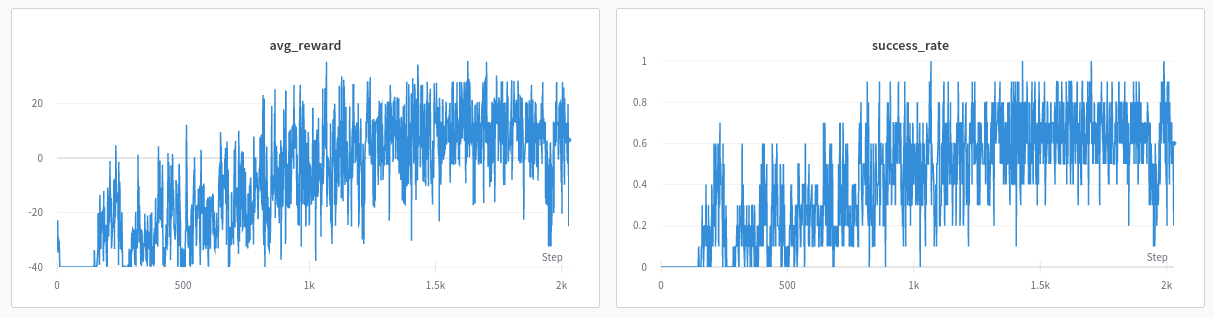

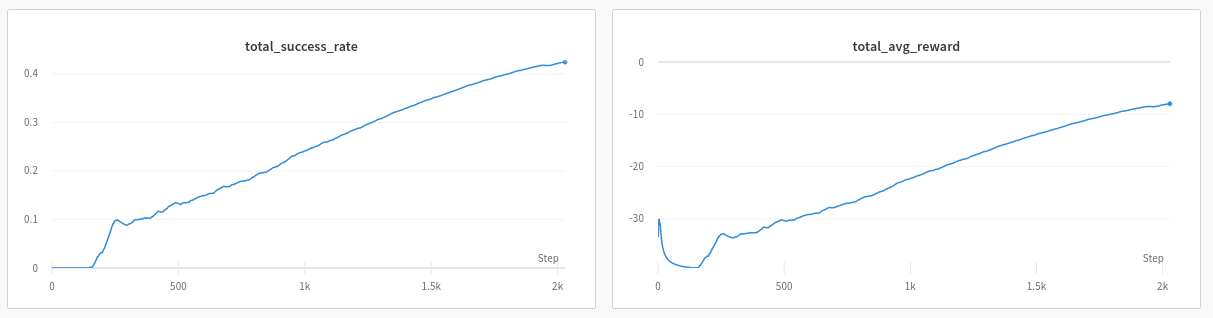

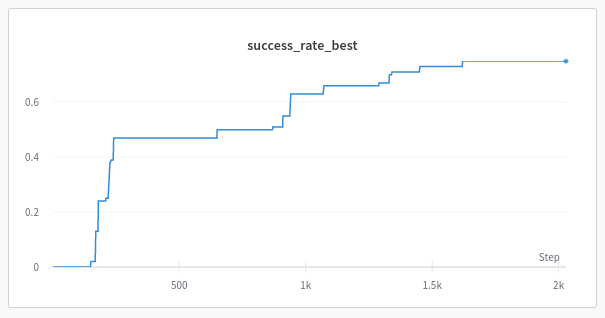

In [30]:
choice_model = pd.DataFrame(columns=['model_name', 'train_time', 'train_success_rate', 'train_average_reward', 'eval_time', 'eval_success_rate', 'eval_average_reward'])

In [32]:
choice_model.to_csv("/kaggle/working/choice_model.csv")

## Валидация

In [33]:
run = wandb.init(
    # Set the project where this run will be logged
    project="go-bot-for-restaurant-reservation",
    # Track hyperparameters and run metadata
    config=dql_constants)

avg_reward,▁▁▁▂▃▁▂▂▂▃▁▃▃▄▁▃▆▃▃▃▅▄▆▃█▅▆▆▆▆▇▆▆█▇▇▆▅▅▆
success_rate,▁▁▁▂▃▁▂▂▃▃▁▃▃▄▁▃▆▃▃▃▅▄▆▃█▆▆▆▆▆▆▆▆█▇▆▆▅▅▆
success_rate_best,▁▁▁▁▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██████████████
total_avg_reward,▂▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
total_success_rate,▁▁▁▁▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████
avg_reward,6.6
success_rate,0.6
success_rate_best,0.75
total_avg_reward,-7.9869
total_success_rate,0.42443


In [36]:
dql_bot.dev()
dql_bot.test_run()

Testing Started...


  0%|          | 0/339 [00:00<?, ?it/s]

Episode: 100, Success Rate: 0.63, Avg Reward: 8.15
Episode: 200, Success Rate: 0.61, Avg Reward: 7.22
Episode: 300, Success Rate: 0.55, Avg Reward: 1.88
Total:
Total Success: 204, Total Success Rate: 0.6017699115044248, Total Avg Reward: 6.061946902654867
...Testing Ended


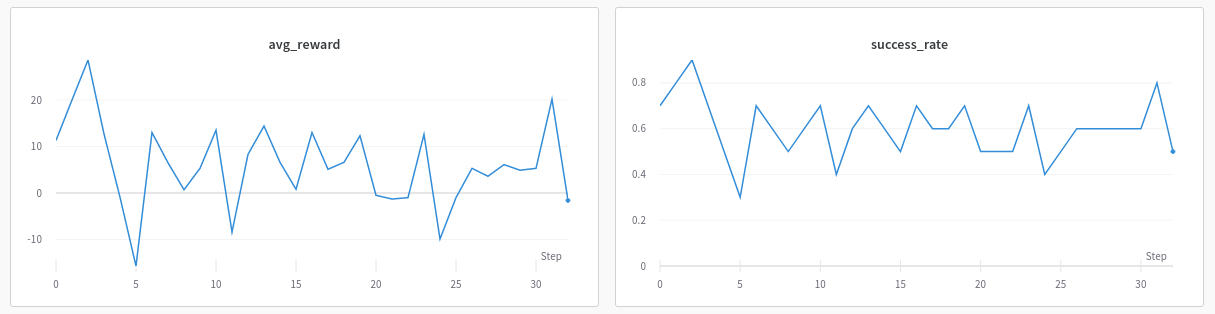

In [41]:
choice_model = choice_model.append({"model_name": 'DQN', 
                     "train_time": dql_bot.stats[TRAIN]['time'], 
                     "train_success_rate": dql_bot.stats[TRAIN]['success_rate'], 
                     "train_average_reward": dql_bot.stats[TRAIN]['reward'],
                     "eval_time": dql_bot.stats[DEV]['time'],
                     "eval_success_rate": dql_bot.stats[DEV]['success_rate'],
                     "eval_average_reward": dql_bot.stats[DEV]['reward']
                    }, ignore_index=True)

/tmp/ipykernel_34/1495266832.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  choice_model = choice_model.append({"model_name": 'DQN',


In [42]:
choice_model.to_csv("/kaggle/working/choice_model.csv")

# Модель #2 (Double-Deep-Q-learning)

Для этой модели был использован немного другой алгоритм, а именно DDQL. Также был увеличен размер hidden_size на 50%

In [46]:
ddql_constants = {
  "db_file_paths": {
    "database": "/kaggle/input/coursework-dt/restaurant_db.pickle",
    "dict": "/kaggle/input/coursework-dt/restaurant_db_dict.pickle",
    "user_goals": "/kaggle/input/coursework-dt/train_goals.json",
    "dev_goals": "/kaggle/input/coursework-dt/dev_goals.json",
    "test_goals": "/kaggle/input/coursework-dt/test_goals.json"
  },
  "run": {
    "usersim": True,
    "warmup_mem": 1000,
    "num_ep_run": 40000,
    "num_ep_test": 5000,
    "train_freq": 100,
    "max_round_num": 20,
    "success_rate_threshold": 0.3,
    "train_log_path": "/kaggle/working/ddql_history_train.json",
    "test_log_path": "/kaggle/working/ddql_history_test.json",
    "dev_log_path": "/kaggle/working/ddql_history_dev.json",
    "early_stopping_rounds": 40,
    "early_stopping_delay": 100
  },
  "agent": {
    "save_weights_file_path": "/kaggle/working/ddql_model.h5",
    "load_weights_file_path": "",
    "vanilla": False,
    "learning_rate": 1e-3,
    "batch_size": 16,
    "dqn_hidden_size": 120,
    "epsilon_init": 0.0,
    "gamma": 0.9,
    "max_mem_size": 500000
  },
  "emc": {
    "slot_error_mode": 0,
    "slot_error_prob": 0.05,
    "intent_error_prob": 0.0
  }
}

In [47]:
ddql_bot = GOBot(constants=ddql_constants)

## Тренировка

In [48]:
run = wandb.init(
    # Set the project where this run will be logged
    project="go-bot-for-restaurant-reservation",
    # Track hyperparameters and run metadata
    config=ddql_constants)

avg_reward,▅▇█▅▃▁▆▅▄▄▆▂▅▆▅▄▆▄▅▅▃▃▃▅▂▃▄▄▄▄▄▇▃
success_rate,▆▇█▆▃▁▆▅▃▅▆▂▅▆▅▃▆▅▅▆▃▃▃▆▂▃▅▅▅▅▅▇▃
avg_reward,-1.6
success_rate,0.5


In [ ]:
ddql_bot.train()
ddql_bot.warmup_run()
ddql_bot.train_run()

Warmup Started...


  0%|          | 0/1000 [00:00<?, ?it/s]

...Warmup Ended
Training Started...


  0%|          | 0/40000 [00:00<?, ?it/s]

Episode: 700 NEW BEST SUCCESS RATE: 0.05 Avg Reward: -34.94
Episode: 800 NEW BEST SUCCESS RATE: 0.06 Avg Reward: -33.56
Episode: 1000 NEW BEST SUCCESS RATE: 0.09 Avg Reward: -31.31
Episode: 1100 NEW BEST SUCCESS RATE: 0.21 Avg Reward: -22.09
Episode: 2100 NEW BEST SUCCESS RATE: 0.27 Avg Reward: -17.2
Episode: 2200 NEW BEST SUCCESS RATE: 0.33 Avg Reward: -14.82
Episode: 2300 NEW BEST SUCCESS RATE: 0.34 Avg Reward: -15.01
Episode: 3400 NEW BEST SUCCESS RATE: 0.45 Avg Reward: -5.58
Episode: 3500 NEW BEST SUCCESS RATE: 0.52 Avg Reward: 0.09
Episode: 4300 NEW BEST SUCCESS RATE: 0.56 Avg Reward: 4.3
Episode: 4400 NEW BEST SUCCESS RATE: 0.65 Avg Reward: 10.24
Episode: 6600 NEW BEST SUCCESS RATE: 0.66 Avg Reward: 10.25
Episode: 9100 NEW BEST SUCCESS RATE: 0.69 Avg Reward: 12.74
Episode: 9600 NEW BEST SUCCESS RATE: 0.7 Avg Reward: 13.63
Episode: 9700 NEW BEST SUCCESS RATE: 0.73 Avg Reward: 15.28
Episode: 10200 NEW BEST SUCCESS RATE: 0.75 Avg Reward: 16.8
Episode: 13400 NEW BEST SUCCESS RATE: 0.

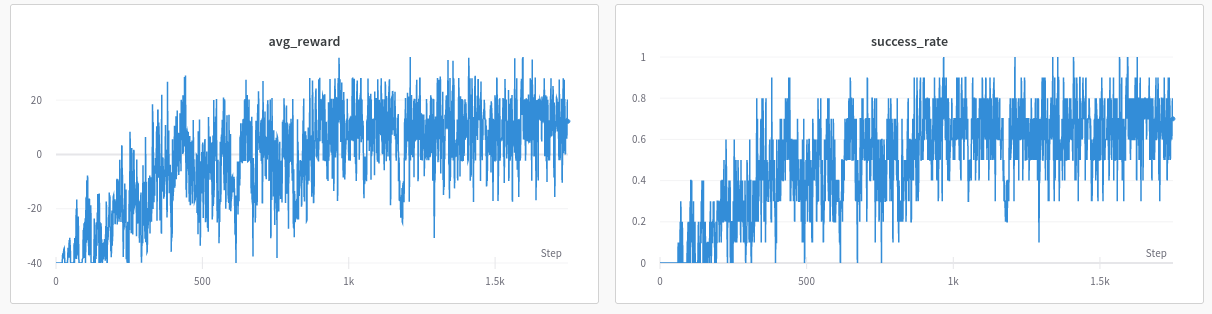

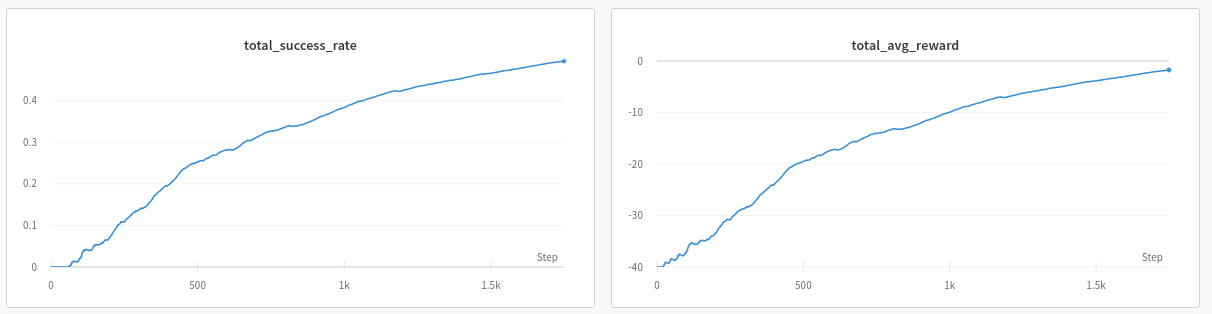

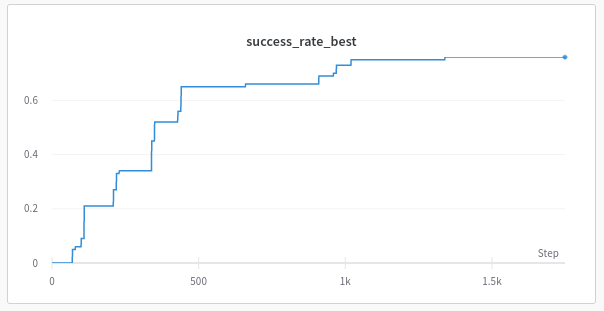

## Валидация

In [55]:
run = wandb.init(
    # Set the project where this run will be logged
    project="go-bot-for-restaurant-reservation",
    # Track hyperparameters and run metadata
    config=ddql_constants)

avg_reward,▁▂▃▄▃▄▄▃▅▄▆▅▅▇▅▅▆▄▇▄▇█▆▅█▆▇▆▅▄▅▆█▄█▅▇▄█▇
success_rate,▁▁▃▅▃▄▄▄▅▄▆▅▅▇▅▅▆▄▇▄▇█▆▅█▆▇▆▅▅▅▆█▄█▅▇▅█▇
success_rate_best,▁▁▂▃▃▄▄▄▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
total_avg_reward,▁▁▁▂▂▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇████████
total_success_rate,▁▁▁▂▂▂▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
avg_reward,12.2
success_rate,0.7
success_rate_best,0.76
total_avg_reward,-1.72937
total_success_rate,0.4956


In [56]:
ddql_bot.dev()
ddql_bot.test_run()

Testing Started...


  0%|          | 0/339 [00:00<?, ?it/s]

Episode: 100, Success Rate: 0.73, Avg Reward: 15.69
Episode: 200, Success Rate: 0.75, Avg Reward: 17.01
Episode: 300, Success Rate: 0.66, Avg Reward: 10.58
Total:
Total Success: 235, Total Success Rate: 0.6932153392330384, Total Avg Reward: 12.902654867256636
...Testing Ended


In [65]:
ddql_bot.dqn_agent.save_weights()

In [58]:
choice_model = choice_model.append({"model_name": 'DDQN', 
                     "train_time": ddql_bot.stats[TRAIN]['time'], 
                     "train_success_rate": ddql_bot.stats[TRAIN]['success_rate'], 
                     "train_average_reward": ddql_bot.stats[TRAIN]['reward'],
                     "eval_time": ddql_bot.stats[DEV]['time'],
                     "eval_success_rate": ddql_bot.stats[DEV]['success_rate'],
                     "eval_average_reward": ddql_bot.stats[DEV]['reward']
                    }, ignore_index=True)

/tmp/ipykernel_34/130415645.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  choice_model = choice_model.append({"model_name": 'DDQN',


In [60]:
choice_model.to_csv("/kaggle/working/choice_model.csv")

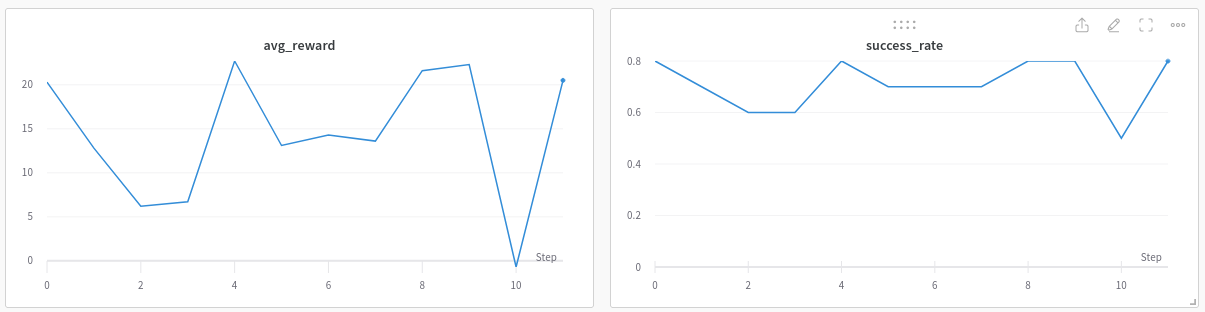

# Модель 3(Double DQN с более глубокой архитектурой)

## Архитектура

In [66]:
class DQNAgetnWithDeeperFCLayers(DQNAgent):
    def _build_model(self):
        """Builds and returns model/graph of neural network."""
        model = nn.Sequential(
            nn.Linear(self.state_size, self.hidden_size, dtype=float),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size, dtype=float),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.num_actions, dtype=float)
        )
        return model.to(self.device)

## Гиперпараметры

In [67]:
deep_ddql_constants = {
  "db_file_paths": {
    "database": "/kaggle/input/coursework-dt/restaurant_db.pickle",
    "dict": "/kaggle/input/coursework-dt/restaurant_db_dict.pickle",
    "user_goals": "/kaggle/input/coursework-dt/train_goals.json",
    "dev_goals": "/kaggle/input/coursework-dt/dev_goals.json",
    "test_goals": "/kaggle/input/coursework-dt/test_goals.json"
  },
  "run": {
    "usersim": True,
    "warmup_mem": 1000,
    "num_ep_run": 40000,
    "num_ep_test": 5000,
    "train_freq": 100,
    "max_round_num": 30,
    "success_rate_threshold": 0.3,
    "train_log_path": "/kaggle/working/deep_ddql_history_train.json",
    "test_log_path": "/kaggle/working/deep_ddql_history_test.json",
    "dev_log_path": "/kaggle/working/deep_ddql_history_dev.json",
    "early_stopping_rounds": 40,
    "early_stopping_delay": 100
  },
  "agent": {
    "save_weights_file_path": "/kaggle/working/deep_ddql_model.h5",
    "load_weights_file_path": "",
    "vanilla": False,
    "learning_rate": 1e-3,
    "batch_size": 16,
    "dqn_hidden_size": 150,
    "epsilon_init": 0.0,
    "gamma": 0.9,
    "max_mem_size": 500000
  },
  "emc": {
    "slot_error_mode": 0,
    "slot_error_prob": 0.05,
    "intent_error_prob": 0.0
  }
}

In [68]:
deep_ddql_bot = GOBot(constants=deep_ddql_constants, Agent=DQNAgetnWithDeeperFCLayers)

## Тренировка

In [69]:
run = wandb.init(
    # Set the project where this run will be logged
    project="go-bot-for-restaurant-reservation",
    # Track hyperparameters and run metadata
    config=deep_ddql_constants)

avg_reward,▅▅▂██▅▆▇▄▃▇▃▆▁▅██▆▅▃▄▅▇▇▂▄▄▄█▆▅▂▄
success_rate,▅▅▂██▅▇▇▄▂▇▂▇▁▅██▇▅▄▄▅▇▇▂▄▄▄█▇▅▁▄
avg_reward,-1.0
success_rate,0.5


In [ ]:
deep_ddql_bot.train()
deep_ddql_bot.warmup_run()
deep_ddql_bot.train_run()

Warmup Started...


  0%|          | 0/1000 [00:00<?, ?it/s]

...Warmup Ended
Training Started...


  0%|          | 0/40000 [00:00<?, ?it/s]

Episode: 400 NEW BEST SUCCESS RATE: 0.01 Avg Reward: -48.15
Episode: 600 NEW BEST SUCCESS RATE: 0.05 Avg Reward: -49.07
Episode: 1200 NEW BEST SUCCESS RATE: 0.14 Avg Reward: -42.31
Episode: 1900 NEW BEST SUCCESS RATE: 0.17 Avg Reward: -40.13
Episode: 2300 NEW BEST SUCCESS RATE: 0.25 Avg Reward: -22.86
Episode: 2400 NEW BEST SUCCESS RATE: 0.27 Avg Reward: -20.29
Episode: 2500 NEW BEST SUCCESS RATE: 0.28 Avg Reward: -14.72
Episode: 2700 NEW BEST SUCCESS RATE: 0.34 Avg Reward: -16.77
Episode: 3000 NEW BEST SUCCESS RATE: 0.36 Avg Reward: -14.72
Episode: 3100 NEW BEST SUCCESS RATE: 0.39 Avg Reward: -10.91
Episode: 3200 NEW BEST SUCCESS RATE: 0.41 Avg Reward: -7.72
Episode: 4200 NEW BEST SUCCESS RATE: 0.45 Avg Reward: -0.24
Episode: 4300 NEW BEST SUCCESS RATE: 0.5 Avg Reward: 2.32
Episode: 5900 NEW BEST SUCCESS RATE: 0.51 Avg Reward: 0.31
Episode: 6000 NEW BEST SUCCESS RATE: 0.57 Avg Reward: 5.16
Episode: 7100 NEW BEST SUCCESS RATE: 0.67 Avg Reward: 17.44
Episode: 9000 NEW BEST SUCCESS RATE:

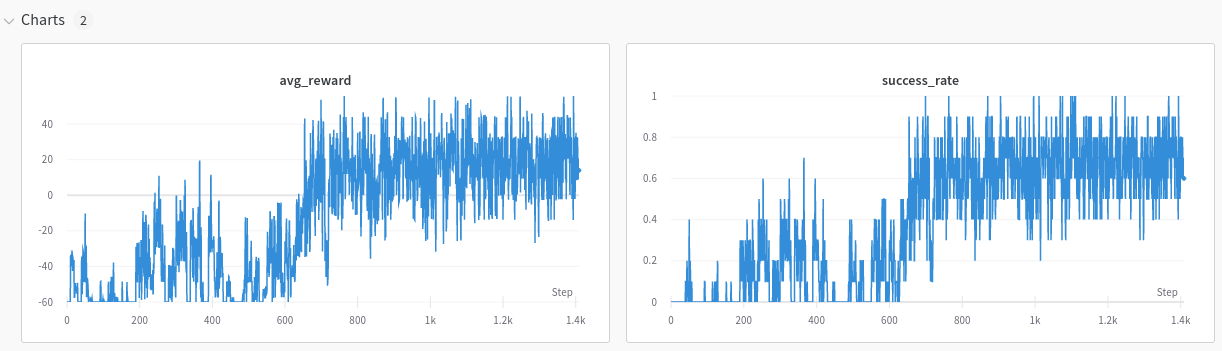

## Валидация

In [ ]:
run = wandb.init(
    # Set the project where this run will be logged
    project="go-bot-for-restaurant-reservation",
    # Track hyperparameters and run metadata
    config=deep_ddql_constants)

In [ ]:
deep_ddql_bot.dev()
deep_ddql_bot.clear_logfile()
deep_ddql_bot.test_run()

Episode: 100, Success Rate: 0.74, Avg Reward: 25.15 \
Episode: 200, Success Rate: 0.78, Avg Reward: 30.08 \
Episode: 300, Success Rate: 0.64, Avg Reward: 13.84 \
Total: \
Total Success: 245, Total Success Rate: 0.7227138643067846, Total Avg Reward: 23.365781710914455

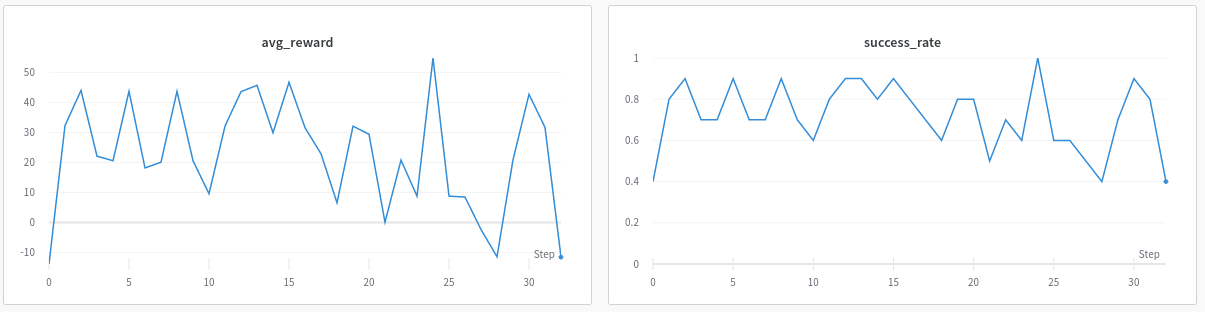